# Calculating and Setting Thresholds to Optimise Logistic Regression Performance

How to create a simple class to optimise thresholds for precision, recall, f1 score, accuracy, tpr - fpr or  custom cost functions.

## Background
I had learned about logistic regression, confusion matrices, ROC curves, thresholds etc. on the various data science courses I have undertaken but I never fully understood them and wanted to explore them in more detail.

Also I had seen various examples online about how to recalculate the true and false classifications given a chosen threshold but these examples fell short of the detail I needed to put thresholds to work in the real world.

I suspected there might be a way to wrap threshold optimisation into a simple, object-oriented class so I could use them easily in future hence this article documents my learning journey to achieve these objectives. 

## Preparation
Let's start by importing the libraries we will need ...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix

We will also need some data to operate on. The data I selected was the bank credit default data from Kaggle - https://www.kaggle.com/c/credit-default-prediction-ai-big-data/overview.

I have performed some cleaning of that data including dealing with the null values, converting the categorical features and balancing the data to evenly represent the true and false classifications which is outside of the scope of this article. The data imported below includes all of those data cleaning steps ...

In [2]:
df_credit = pd.read_csv("data/bank_credit.csv")
df_credit

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,482087.0,6,0.0,11.0,26.3,685960.0,1.0,1.0,99999999.0,47386.0,...,0,0,0,0,0,0,0,0,0,1
1,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,0.0,264968.0,394972.0,...,0,0,0,0,0,0,0,0,1,0
2,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,0.0,99999999.0,308389.0,...,0,0,0,0,0,0,0,0,0,1
3,805068.0,6,0.0,8.0,22.5,147400.0,1.0,1.0,121396.0,95855.0,...,0,0,0,0,0,0,0,0,0,1
4,776264.0,8,0.0,13.0,13.6,385836.0,1.0,0.0,125840.0,93309.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5938,2833185.0,6,0.0,18.0,21.3,280170.0,0.0,0.0,437404.0,108889.0,...,0,0,0,0,0,0,0,0,0,1
5939,1257610.0,8,0.0,14.0,16.5,821480.0,0.0,0.0,448052.0,167428.0,...,0,0,0,0,0,0,0,0,1,0
5940,402192.0,0,0.0,3.0,8.5,107866.0,0.0,0.0,129360.0,73492.0,...,0,0,0,1,0,0,0,0,0,1
5941,1533984.0,1,0.0,10.0,26.5,686312.0,0.0,0.0,444048.0,456399.0,...,0,0,0,0,0,0,0,0,1,0


Let's complete the preparation by splitting the data into testing and training so we can optimise against the training data and come back to the test data later on ...

In [3]:
X = df_credit.drop('Credit Default', axis=1)
y = df_credit['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4754, 32), (1189, 32), (4754,), (1189,))

## Benchmarking
### Initial Analysis
OK, let's fit a basic ``LogisticRegression`` to the test data and then review the results ...

In [4]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)
y_pred

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

A visualisation of the confusion matrix will help us to evaluate the performance ...

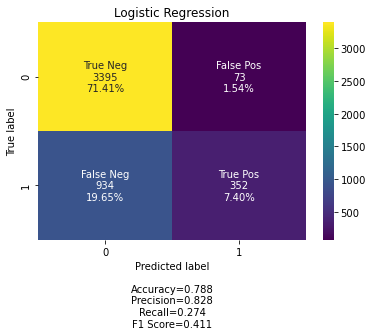

The banking data is being used to predict customers who will go on to default against their credit agreements and those who will not default.

We can see straight away that a basic logistic regression has 79% accuracy having predicted 352 customers that will default and 3395 customers who will not.

That sounds pretty good right? Well if I was one of the managers taking delivery of this algorithm my immediate question would be - "what about the 934 false negatives?". There are nearly a 1000 customers that the algorithm did not predict as defaulting who went on to default.

If the average cost of a default account to the bank is £10,000 my data science team has just cost the business £9.34m and I would definitely not be happy with that!

This simple analysis reveals three key points -

- The ``accuracy`` measure may not always be the best way to evaluate the performance of a classification algorithm.
- The way in which a classification algorithm is optimised is heavily dependent on what the business is trying to achieve.
- The algorithm must be appropriately optimised to achieve the desired business outcomes.

### Further Analysis
A bit more digging will reveal all of the key metrics for the performance of our basic algorithm -

``
accuracy = 0.7881783761043332
precision = 0.8282352941176471
recall = 0.2737169517884914
f1 score = 0.4114552893045003
true positive rate (tpr) = 0.2737169517884914
false positive rate (fpr) = 0.02104959630911188
tpr-fpr = 0.2526673554793796
``

I would also usually take a look at the ROC (Receiver Operating Characteristic) curve -

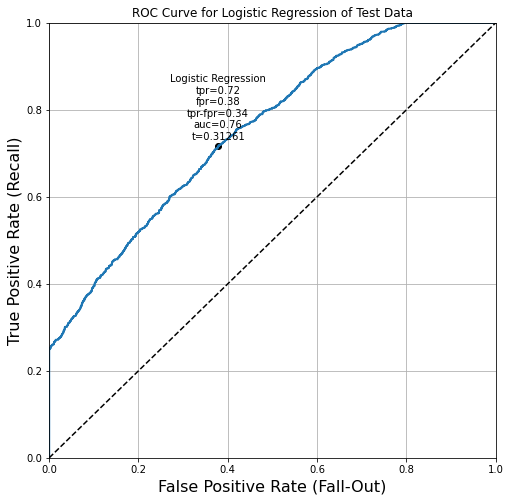

The black dot represents one interpretation of the optimum point. 

One measure that can be used is for calculating the optimum point on a ROC curve is $TPR - FPR$ where $TPR$ = True Positive Rate and $FPR$ = False Positive Rate. The point at which the $TPR-FPR$ is at its maximum value is the optimum point.

The graph is showing that if we set the threshold of the logistic regression to 0.31261 instead of the default which is 0.5 then we optimise the logistic regression algorithm for $TPR-FPR$.

### A Quick Recap on Thresholds
If all this talk of thresholds is confusing there are many online articles that will explain the details, but the easiest way of envisaging it is this -

Each row of our data will be classified as ``Default=True`` or ``Default=False``. The logistic regression assigns each row a probability of bring ``True`` and then makes a prediction for each row where that prbability  is >= 0.5 i.e. 0.5 is the default threshold. 

Once we understand a bit more about how this works we can play around with that 0.5 default to improve and optimise the outcome of our predictive algorithm.

### Analysis Conclusion
From this quick analysis the evidence suggests we can do better than accepting the default threshold of 0.5 that is implemented within the ``LogisticRegression`` algotithm that is part of the ``sklearn.linear_model`` library. For example, we already know that if we change that default to 0.31261 we will optimise for $TPR - FPR$.

However there is no easy way to change the threshold within the ``LogisticRegression`` class and typically data scientists will do this bit manually and duplicate effort across multiple projects.

What we need is a simple class that will do this for us every time we want to optimise the threshold.

## Automating the Threshold Calculation

Here is my first attempt at writing a class that extends the ``LogisticRegression`` class to optimise the threshold based on the $TPR-FPR$ calcualtion. It consists of a class definition, a method called ``threshold_from_optimal_tpr_minus_fpr`` and a ``predict`` method which over-rides the base class method enabling the ``threshold`` parameter to be passed in ...

In [5]:
class LogisticRegressionWithThreshold(LogisticRegression):
    def predict(self, X, threshold=None):
        if threshold == None: # If no threshold passed in, simply call the base class predict, effectively threshold=0.5
            return LogisticRegression.predict(self, X)
        else:
            y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
            y_pred_with_threshold = (y_scores >= threshold).astype(int)

            return y_pred_with_threshold
    
    def threshold_from_optimal_tpr_minus_fpr(self, X, y):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        fpr, tpr, thresholds = roc_curve(y, y_scores) 

        optimal_idx = np.argmax(tpr - fpr)

        return thresholds[optimal_idx], tpr[optimal_idx] - fpr[optimal_idx]

Armed with this new utility class we can now easily fit the training data to it, ask the class to tell us the optimal threshold for $TPR-FPR$ and then use that threshold to return a new set of predictions ...

In [6]:
lrt = LogisticRegressionWithThreshold()
lrt.fit(X_train, y_train)

threshold, optimal_tpr_minus_fpr = lrt.threshold_from_optimal_tpr_minus_fpr(X_train, y_train)
y_pred = lrt.predict(X_train, threshold)

threshold, optimal_tpr_minus_fpr

(0.3126109044627986, 0.3383474055618039)

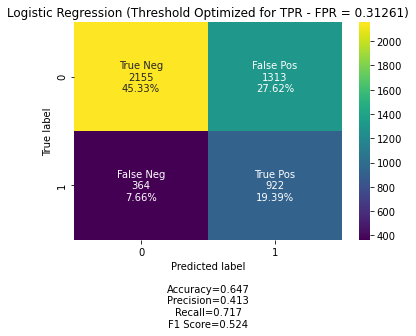

Well, this optimisation has certainly changed the shape of the outcomes as shown by the confusion matrix. The false negatives and true negatives have reduced whilst the false positives and true positives have increased.

This finding led me to ask the question - "what other approaches are there to optimisation?"

### A Quick Recap on Precision and Recall
Another way of evaluating the outcomes of a classification algorithm is to plot the precision and recall for the confusion matrix rather than the FPR and TPR.

As a quick reminder, precision and recall are calculated as follows -

$$Precision = \frac{True Positives}{(True Positives + False Positives)}$$

$$Recall = \frac{True Positives}{(True Positives + False Negatives)}$$

I.e. Precision is the right hand column of the confusion matrix and precision is the bottom row.

Where as $TPR-FPR$ is commonly used to pick the optimum point on the ROC curve, the F1 score can be used to pick the optimum point on the precision-recall curve. The F1 Score is calculated as follows -

$$F1 = \frac{2 \times Precision \times Recall}{(Precision + Recall)}$$

The F1 score is the harmonic mean of precision and recall. We use the harmonic mean instead of a simple average because it punishes extreme values.

The plot of precision vs. recall for our default algorithm looks like this -

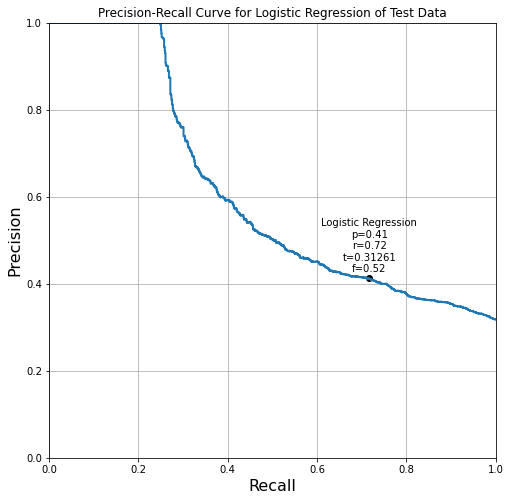

Here we can see that the optimum (i.e. the maximum) F1 score is 0.5237148537347345 with the optimum precision and recall being 0.41 and 0.72 respectively. The threshold that would produce this outcome from the algorithm is 0.3126109044627986

## Automating the Threshold Calculation Take 2
This second attempt at extending the ``LogisticRegression`` class added a new method for optimising for the F1 score to produce the optimal precision and threshold values -

In [7]:
class LogisticRegressionWithThreshold(LogisticRegression):
    def predict(self, X, threshold=None):
        if threshold == None: # If no threshold passed in, simply call the base class predict, effectively threshold=0.5
            return LogisticRegression.predict(self, X)
        else:
            y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
            y_pred_with_threshold = (y_scores >= threshold).astype(int)

            return y_pred_with_threshold
    
    def threshold_from_optimal_tpr_minus_fpr(self, X, y):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        fpr, tpr, thresholds = roc_curve(y, y_scores) 

        optimal_idx = np.argmax(tpr - fpr)

        return thresholds[optimal_idx], tpr[optimal_idx] - fpr[optimal_idx]
    
    def threshold_from_optimal_f_score(self, X, y):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

        fscores = (2 * precisions * recalls) / (precisions + recalls)
        
        optimal_idx = np.argmax(fscores)
        
        return thresholds[optimal_idx], fscores[optimal_idx]

Now we can easily use the new version of the class to tell me what the threshold needs to be to optimise the f1 score and then to use that value to fine-tune the algorithm for the optimum precision and recall ...

In [8]:
lrt = LogisticRegressionWithThreshold()
lrt.fit(X_train, y_train)

threshold, optimal_f1_score = lrt.threshold_from_optimal_f_score(X_train, y_train)
y_pred = lrt.predict(X_train, threshold)

threshold, optimal_f1_score

(0.3126109044627986, 0.5237148537347345)

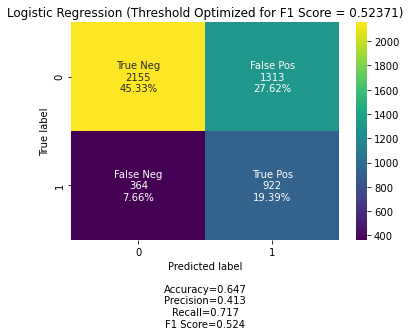

This version has significantly reduced the false negatives and represents the maximum possible optimisation of precision and recall.

Now imagine I took the new model back to the managment team at the bank and they said "Well, that is an improvement but we absolutely have to have a recall of 90% for this model to be effective".

Remember, recall is $TP / (TP+FN)$ and at the moment this model has 922 / (364+922) = 71.7%.

We would need to explain to the management team that recall and precision are trade offs so if the model is tuned for 90% recall the precision must decrease but if that were acceptable, how could this be achieved?

## Automating the Threshold Calculation Take 3
This third attempt adds two new methods to calculate the required threshold for a given specific recall (and precision) which can now be used to achieve the performance requested by the management team -

In [9]:
class LogisticRegressionWithThreshold(LogisticRegression):
    def predict(self, X, threshold=None):
        if threshold == None: # If no threshold passed in, simply call the base class predict, effectively threshold=0.5
            return LogisticRegression.predict(self, X)
        else:
            y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
            y_pred_with_threshold = (y_scores >= threshold).astype(int)

            return y_pred_with_threshold
    
    def threshold_from_optimal_tpr_minus_fpr(self, X, y):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        fpr, tpr, thresholds = roc_curve(y, y_scores) 

        optimal_idx = np.argmax(tpr - fpr)

        return thresholds[optimal_idx], tpr[optimal_idx] - fpr[optimal_idx]
    
    def threshold_from_optimal_f_score(self, X, y):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

        fscores = (2 * precisions * recalls) / (precisions + recalls)
        
        optimal_idx = np.argmax(fscores)
        
        return thresholds[optimal_idx], fscores[optimal_idx]
        
    def threshold_from_desired_precision(self, X, y, desired_precision=0.9):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

        desired_precision_idx = np.argmax(precisions >= desired_precision)
        
        return thresholds[desired_precision_idx], recalls[desired_precision_idx]

    def threshold_from_desired_recall(self, X, y, desired_recall=0.9):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

        desired_recall_idx = np.argmin(recalls >= desired_recall)
        
        return thresholds[desired_recall_idx], precisions[desired_recall_idx]

In [10]:
lrt = LogisticRegressionWithThreshold()
lrt.fit(X_train, y_train)

threshold, precision = lrt.threshold_from_desired_recall(X_train, y_train, 0.9)
y_pred = lrt.predict(X_train, threshold)

threshold, precision

(0.19142214362243234, 0.35382262996941893)

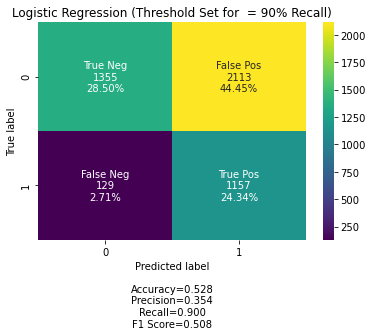

We can see that the recall requested by the management team has been achieved and that as a result the precision has been traded off from 41.3% to 35.4%.

## Automating the Threshold Calculation Take 4
At this point I was getting rather carried away and I wanted a version of the optimisation that would implement a custom cost function.

Let's suppose the management team now give us the following new information -

- Every true negative means we can sell £10,000 of additional credit products to customers who will not default.
- Every false positive costs us £1,000 because we could have engaged those customers but instead we avoided them.
- Every false negative costs us £1,500 because we failed to intervene and stop those customers defaulting.
- Every true positive helps us to prevent credit default and each one generates £20,000 of new income.

A "cost function" to implement this can easily be constructed -

In [11]:
def default_cost_function(tn, fp, fn, tp):
    cost = 0
    
    cost += (tn * -10000) 
    cost += (fp * 1000) 
    cost += (fn * 1500) 
    cost += (tp * -20000) 
    
    return cost

And with a bit more work we can modify our class to work out the threshold required to optimise this cost function and then apply it -

In [12]:
class LogisticRegressionWithThreshold(LogisticRegression):
    def predict(self, X, threshold=None):
        if threshold == None: # If no threshold passed in, simply call the base class predict, effectively threshold=0.5
            return LogisticRegression.predict(self, X)
        else:
            y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
            y_pred_with_threshold = (y_scores >= threshold).astype(int)

            return y_pred_with_threshold
    
    def threshold_from_optimal_tpr_minus_fpr(self, X, y):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        fpr, tpr, thresholds = roc_curve(y, y_scores) 

        optimal_idx = np.argmax(tpr - fpr)

        return thresholds[optimal_idx], tpr[optimal_idx] - fpr[optimal_idx]
    
    def threshold_from_optimal_f_score(self, X, y):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

        fscores = (2 * precisions * recalls) / (precisions + recalls)
        
        optimal_idx = np.argmax(fscores)
        
        return thresholds[optimal_idx], fscores[optimal_idx]
        
    def threshold_from_desired_precision(self, X, y, desired_precision=0.9):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

        desired_precision_idx = np.argmax(precisions >= desired_precision)
        
        return thresholds[desired_precision_idx], recalls[desired_precision_idx]

    def threshold_from_desired_recall(self, X, y, desired_recall=0.9):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

        desired_recall_idx = np.argmin(recalls >= desired_recall)
        
        return thresholds[desired_recall_idx], precisions[desired_recall_idx]
    
    def threshold_from_cost_function(self, X, y, cost_function):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

        costs = []
        tns = []
        fps = []
        fns = []
        tps = []
        
        for threshold in thresholds:
            y_pred_with_threshold = (y_scores >= threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(y, y_pred_with_threshold).ravel()
            costs.append(cost_function(tn, fp, fn, tp))
            tns.append(tn), fps.append(fp), fns.append(fn), tps.append(tp)

        df_cost = pd.DataFrame({'precision':precisions[:-1], 'recall':recalls[:-1], 'threshold':thresholds, 'cost':costs, 'tn':tns, 'fp':fps, 'fn':fns, 'tp':tps})
        
        min_cost = df_cost['cost'].min()
        threshold = df_cost[df_cost['cost']==min_cost].iloc[0]['threshold']

        return threshold, min_cost, df_cost

... which can be used as follows -

In [13]:
lrt = LogisticRegressionWithThreshold()
lrt.fit(X_train, y_train)

threshold, min_cost, df_cost = lrt.threshold_from_cost_function(X_train, y_train, default_cost_function)
y_pred = lrt.predict(X_train, threshold)

threshold, min_cost

(0.4324142856743824, -40033500)

The new confusion matrix looks like this ..

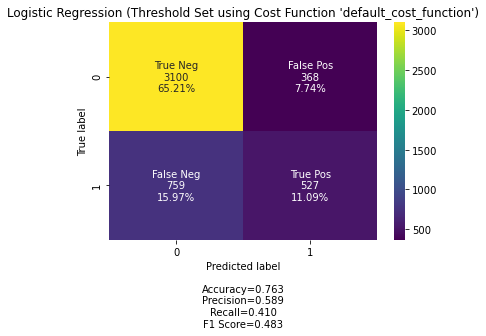

... and here is the plot of our custom cost function values vs. the threshold values ...

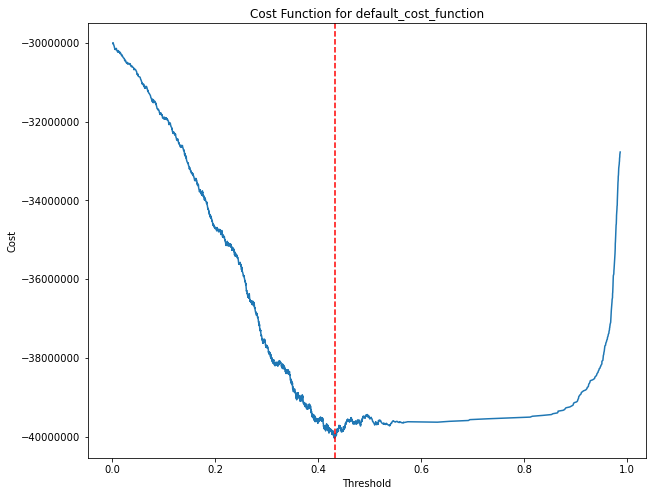

## Automating the Threshold Calculation - Final Version
Given that I had realised that the threshold for optimal accuracy could be calculated using a very similar approach to that for a custom cost function, I thought I would add that into the final version.

After all, many of the data science competitions do evaluate based on accuracy even though I had come to consider that it is not always, and in fact not often, the best measure of effectiveness of a classification algorithm. 

That being said when I plugged the threshold for optimum accuracy calculated using the training data into the test data it lifted the accuracy measure of the predictions by a whole 1% and in a data science competition that might just make a difference!

The full code for the final version of the ``LogisticRegressionWithThreshold`` class is as follows -

In [14]:
class LogisticRegressionWithThreshold(LogisticRegression):
    def predict(self, X, threshold=None):
        if threshold == None: # If no threshold passed in, simply call the base class predict, effectively threshold=0.5
            return LogisticRegression.predict(self, X)
        else:
            y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
            y_pred_with_threshold = (y_scores >= threshold).astype(int)

            return y_pred_with_threshold
    
    def threshold_from_optimal_tpr_minus_fpr(self, X, y):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        fpr, tpr, thresholds = roc_curve(y, y_scores) 

        optimal_idx = np.argmax(tpr - fpr)

        return thresholds[optimal_idx], tpr[optimal_idx] - fpr[optimal_idx]
    
    def threshold_from_optimal_f_score(self, X, y):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

        fscores = (2 * precisions * recalls) / (precisions + recalls)
        
        optimal_idx = np.argmax(fscores)
        
        return thresholds[optimal_idx], fscores[optimal_idx]
        
    def threshold_from_desired_precision(self, X, y, desired_precision=0.9):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

        desired_precision_idx = np.argmax(precisions >= desired_precision)
        
        return thresholds[desired_precision_idx], recalls[desired_precision_idx]

    def threshold_from_desired_recall(self, X, y, desired_recall=0.9):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

        desired_recall_idx = np.argmin(recalls >= desired_recall)
        
        return thresholds[desired_recall_idx], precisions[desired_recall_idx]
    
    def threshold_from_cost_function(self, X, y, cost_function):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

        costs = []
        tns = []
        fps = []
        fns = []
        tps = []
        
        for threshold in thresholds:
            y_pred_with_threshold = (y_scores >= threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(y, y_pred_with_threshold).ravel()
            costs.append(cost_function(tn, fp, fn, tp))
            tns.append(tn), fps.append(fp), fns.append(fn), tps.append(tp)

        df_cost = pd.DataFrame({'precision':precisions[:-1], 'recall':recalls[:-1], 'threshold':thresholds, 'cost':costs, 'tn':tns, 'fp':fps, 'fn':fns, 'tp':tps})
        
        min_cost = df_cost['cost'].min()
        threshold = df_cost[df_cost['cost']==min_cost].iloc[0]['threshold']

        return threshold, min_cost, df_cost
    
    def threshold_from_optimal_accuracy(self, X, y):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
        
        accuracies = []
        tns = []
        fps = []
        fns = []
        tps = []

        for threshold in thresholds:
            y_pred_with_threshold = (y_scores >= threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(y, y_pred_with_threshold).ravel()

            accuracies.append((tp+tn)/(tn+fp+fn+tp))
            tns.append(tn), fps.append(fp), fns.append(fn), tps.append(tp)
        
        df_accuracy = pd.DataFrame({'threshold':thresholds, 'accuracy':accuracies, 'tn':tns, 'fp':fps, 'fn':fns, 'tp':tps})

        max_accuracy = df_accuracy['accuracy'].max()
        threshold = df_accuracy[df_accuracy['accuracy']==max_accuracy].iloc[0]['threshold']

        return threshold, max_accuracy, df_accuracy

In [15]:
lrt = LogisticRegressionWithThreshold()
lrt.fit(X_train, y_train)

threshold, max_accuracy, df_accuracy = lrt.threshold_from_optimal_accuracy(X_train, y_train)
y_pred = lrt.predict(X_train, threshold)

threshold, max_accuracy

(0.5654501621491699, 0.7968026924694994)

Here is the confusion matrix for the optimal (highest) accuracy ...

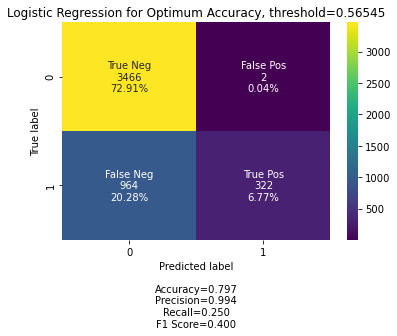

... and here is the plot of accuracy vs. threshold ...

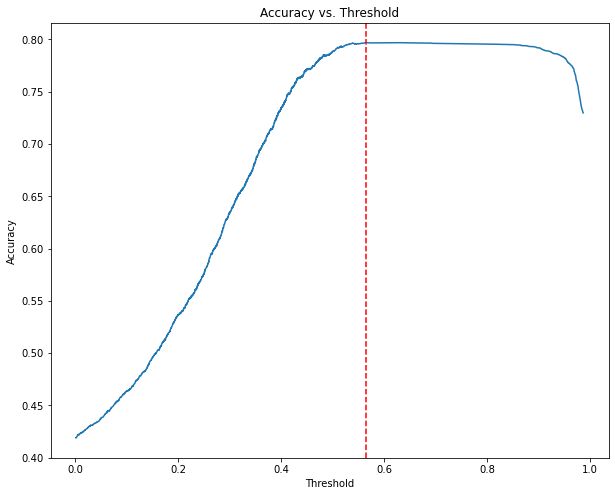

## Conclusion
We have seen that there are many ways to optimise a logistic regression which incidentally can be applied to other classification algorithms. These optimisations include finding and setting thresholds for the optimisation of precision, recall, f1 score, accuracy, tpr - fpr or custom cost functions.

We have also seen that the chosen optimisation is heavily dependent on the desired business outcomes.

We have seen that the ``LogisticRegression`` class in ``sklearn.linear_model`` does not have a way to set the threshold so that the algorithm can be optimised but that we can use the ``LogististicRegressionWithThreshold`` class developed in this article to give us instant access to all the functionality necessary to tune the base algorithm according to the desired business outcomes.

## Thank-you for Reading!
If you enjoyed reading this article, why not check out my other articles at https://grahamharrison-86487.medium.com/?

Also, I would love to hear from you to get your thoughts on this piece, any of my other articles or anything else related to data science and data analytics.

I am particularly passionate about the democratization of data science into fields where it is still not the norm, for example the education sector and small-medium sized enterprises. 

I am also very interested in the tendency for academic education in data science to have a high threshold for mathematics and whether this is holding back a lot of individuals with the potential to make a big impact in the data science world.

If you would like to get in touch to discuss any of these topics please look me up on LinkedIn - https://www.linkedin.com/in/grahamharrison1 or feel free to e-mail me at GHarrison@lincolncollege.ac.uk.